In [1]:
#Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("nyc_taxi_trip_duration.csv")

In [3]:
data.shape

(729322, 11)

In [4]:
#Since the dataset is huge, the KNN model takes longer time to be executed so taking only 10000 rows from the dataset
data=data.iloc[0:10000]

In [5]:
data.shape

(10000, 11)

In [6]:
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

In [7]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [8]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [9]:
data.isnull().sum()  #checking for missing values

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [10]:
#performing value_counts() on all columns to check if any datatype can be considered an object and not integer/float
for i in data.columns:
    print(i,":",data[i].value_counts())

id : id1080784    1
id1753579    1
id1905962    1
id1638422    1
id2487762    1
            ..
id3896576    1
id1480881    1
id2037121    1
id3569449    1
id2372397    1
Name: id, Length: 10000, dtype: int64
vendor_id : 2    5424
1    4576
Name: vendor_id, dtype: int64
pickup_datetime : 2016-04-23 10:49:28    2
2016-06-17 22:08:21    2
2016-03-16 19:58:42    2
2016-01-20 07:42:14    2
2016-02-21 20:53:03    2
                      ..
2016-04-10 10:44:17    1
2016-01-30 23:39:30    1
2016-02-16 09:56:19    1
2016-03-20 20:37:59    1
2016-03-31 13:21:06    1
Name: pickup_datetime, Length: 9995, dtype: int64
dropoff_datetime : 2016-06-14 15:34:47    2
2016-05-20 10:42:13    2
2016-05-19 23:43:46    2
2016-04-11 15:19:12    2
2016-06-19 01:45:55    1
                      ..
2016-01-31 00:00:54    1
2016-02-16 10:08:12    1
2016-03-20 20:45:26    1
2016-02-18 09:25:07    1
2016-03-31 13:34:07    1
Name: dropoff_datetime, Length: 9996, dtype: int64
passenger_count : 1    6958
2    1497
5   

In [11]:
#vendor_id and passenger_count are objects and not integers, so changing their datatypes
data['vendor_id']=data['vendor_id'].astype('object')
data['passenger_count']=data['passenger_count'].astype('object')

In [12]:
#pickup_datetime and dropoff_datetime are taken as object, so changing their datatypes
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [13]:
pickup=pd.DatetimeIndex(data['pickup_datetime'])
dropoff=pd.DatetimeIndex(data['dropoff_datetime'])

In [14]:
#creating new columns for date, day, month, year, hour, minute, second from the given datetime columns

In [15]:
data['pickup_date']=pickup.date
data['dropoff_date']=dropoff.date
data['pickup_day']=pickup.day
data['dropoff_day']=dropoff.day
data['pickup_month']=pickup.month
data['dropoff_month']=dropoff.month
data['pickup_year']=pickup.year
data['dropoff_year']=dropoff.year

In [16]:
data['pickup_hour']=pickup.hour
data['dropoff_hour']=dropoff.hour
data['pickup_minute']=pickup.minute
data['dropoff_minute']=dropoff.minute
data['pickup_second']=pickup.second
data['dropoff_second']=dropoff.second

In [17]:
#creating new column for distance from the given latitude and longitude columns

In [18]:
'''
formula for distance from latitudes and longitudes:
a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * asin(sqrt(a))
r = 6371.0 for km
r=3956.0 for miles
distance=c*r
'''

from math import radians, cos, sin, asin, sqrt

lon1 = data['pickup_longitude'].apply(lambda x: x)
lon2 = data['dropoff_longitude'].apply(lambda x: x)
lat1 = data['pickup_latitude'].apply(lambda x: x)
lat2 = data['dropoff_latitude'].apply(lambda x: x)
dlon = lon2 - lon1
dlat = lat2 - lat1
dist=pd.DataFrame({
    'lon1':lon1,
    'lon2':lon2,
    'lat1':lat1,
    'lat2':lat2,
    'dlon':dlon,
    'dlat':dlat
})

#Taking the four terms in a and calculating it separately and storing it in columns named as term1, term2, term3, term4
dist['term1']=dist['dlat'].apply(lambda x: sin(x/2)**2)
dist['term2']=dist['lat1'].apply(lambda x: cos(x))
dist['term3']=dist['lat2'].apply(lambda x: cos(x))
dist['term4']=dist['dlon'].apply(lambda x: sin(x/2)**2)
#calculating a
dist['a']=dist['term1']+dist['term2']*dist['term3']*dist['term4']
#calculating c
dist['c']=dist['a'].apply(lambda x: 2*x*sin(sqrt(x)))
#calculating distance
dist['distance']=dist['c'].apply(lambda x: x*3956.0)


print(dist.head())

        lon1       lon2       lat1       lat2      dlon      dlat     term1  \
0 -73.953918 -73.963875  40.778873  40.771164 -0.009956 -0.007710  0.000015   
1 -73.988312 -73.994751  40.731743  40.694931 -0.006439 -0.036812  0.000339   
2 -73.997314 -73.948029  40.721458  40.774918  0.049286  0.053459  0.000714   
3 -73.961670 -73.956779  40.759720  40.780628  0.004890  0.020908  0.000109   
4 -74.017120 -73.988182  40.708469  40.740631  0.028938  0.032162  0.000259   

      term2     term3     term4         a             c  distance  
0 -0.998089 -0.997583  0.000025  0.000040  4.971446e-07  0.001967  
1 -0.994070 -0.989394  0.000010  0.000349  1.303529e-05  0.051568  
2 -0.992899 -0.997837  0.000607  0.001316  9.544160e-05  0.377567  
3 -0.996723 -0.998196  0.000006  0.000115  2.473979e-06  0.009787  
4 -0.991270 -0.994997  0.000209  0.000465  2.005590e-05  0.079341  


In [19]:
data['distance']=dist['distance']

In [20]:
data.head()

id vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784         2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885         1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912         2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273         2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939         1 2016-02-17 06:42:23 2016-02-17 06:56:31   

  passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               1        -73.953918        40.778873         -73.963875   
1               2        -73.988312        40.731743         -73.994751   
2               2        -73.997314        40.721458         -73.948029   
3               6        -73.961670        40.759720         -73.956779   
4               1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  ...  dropoff_month pickup_year  \
0         40.771164                  N  ...              2        2016   
1         40.694931                  N  ...              3        2016   
2         40.774918                  N  ...              2        2016   
3         40.780628                  N  ...              1        2016   
4         40.740631                  N  ...              2        2016   

  dropoff_year  pickup_hour  dropoff_hour  pickup_minute  dropoff_minute  \
0         2016           16            16             40              47   
1         2016           23            23             35              53   
2         2016           17            18             59              26   
3         2016            9            10             44               3   
4         2016            6             6             42              56   

   pickup_second  dropoff_second  distance  
0             21               1  0.001967  
1             37              57  0.051568  
2             33              48  0.377567  
3             31              32  0.009787  
4             23              31  0.079341  

[5 rows x 26 columns]

In [21]:
#Displaying the additional columns added separately

In [22]:
data[['pickup_datetime','dropoff_datetime','pickup_date','dropoff_date','pickup_day','dropoff_day','pickup_month','dropoff_month',
     'pickup_year','dropoff_year']].head()

pickup_datetime    dropoff_datetime pickup_date dropoff_date  \
0 2016-02-29 16:40:21 2016-02-29 16:47:01  2016-02-29   2016-02-29   
1 2016-03-11 23:35:37 2016-03-11 23:53:57  2016-03-11   2016-03-11   
2 2016-02-21 17:59:33 2016-02-21 18:26:48  2016-02-21   2016-02-21   
3 2016-01-05 09:44:31 2016-01-05 10:03:32  2016-01-05   2016-01-05   
4 2016-02-17 06:42:23 2016-02-17 06:56:31  2016-02-17   2016-02-17   

   pickup_day  dropoff_day  pickup_month  dropoff_month  pickup_year  \
0          29           29             2              2         2016   
1          11           11             3              3         2016   
2          21           21             2              2         2016   
3           5            5             1              1         2016   
4          17           17             2              2         2016   

   dropoff_year  
0          2016  
1          2016  
2          2016  
3          2016  
4          2016

In [23]:
data[['pickup_hour','dropoff_hour','pickup_minute','dropoff_minute','pickup_second',
      'dropoff_second','distance']].head()

pickup_hour  dropoff_hour  pickup_minute  dropoff_minute  pickup_second  \
0           16            16             40              47             21   
1           23            23             35              53             37   
2           17            18             59              26             33   
3            9            10             44               3             31   
4            6             6             42              56             23   

   dropoff_second  distance  
0               1  0.001967  
1              57  0.051568  
2              48  0.377567  
3              32  0.009787  
4              31  0.079341

In [24]:
data.dtypes

id                            object
vendor_id                     object
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count               object
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_date                   object
dropoff_date                  object
pickup_day                     int64
dropoff_day                    int64
pickup_month                   int64
dropoff_month                  int64
pickup_year                    int64
dropoff_year                   int64
pickup_hour                    int64
dropoff_hour                   int64
pickup_minute                  int64
dropoff_minute                 int64
pickup_second                  int64
dropoff_second                 int64
distance                     float64
dtype: object

In [25]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'dropoff_date', 'pickup_day',
       'dropoff_day', 'pickup_month', 'dropoff_month', 'pickup_year',
       'dropoff_year', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'pickup_second', 'dropoff_second', 'distance'],
      dtype='object')

In [26]:
data[['pickup_year','dropoff_year']].value_counts() #to check how many years of data is there

pickup_year  dropoff_year
2016         2016            10000
dtype: int64

In [27]:
#Since only 1 year, all the months can be taken as object
data[['pickup_month','dropoff_month']]=data[['pickup_month','dropoff_month']].astype('object')

In [28]:
data['pickup_hour'].value_counts()

19    652
21    602
18    591
22    581
17    543
20    515
15    506
12    492
10    486
14    485
11    485
8     481
13    471
9     468
23    461
16    421
7     373
0     349
1     245
6     213
2     198
3     155
4     120
5     107
Name: pickup_hour, dtype: int64

In [29]:
data[['pickup_hour','dropoff_hour']]=data[['pickup_hour','dropoff_hour']].astype('object')

In [30]:
data.dtypes

id                            object
vendor_id                     object
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count               object
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_date                   object
dropoff_date                  object
pickup_day                     int64
dropoff_day                    int64
pickup_month                  object
dropoff_month                 object
pickup_year                    int64
dropoff_year                   int64
pickup_hour                   object
dropoff_hour                  object
pickup_minute                  int64
dropoff_minute                 int64
pickup_second                  int64
dropoff_second                 int64
distance                     float64
dtype: object

# 1.Choose the most suitable evaluation metric and state why you choose it.

The target variable in this dataset (trip_duration) is a continuous variable and hence this is a Regression Model

The most suitable evaluation metric is RMSE. Choosing MSE would square the unit of my target variable (here the target variable
trip_duration given in seconds, MSE would give me the error in seconds^2), so I am choosing RMSE.

Also RMSE is one of the most commonly used evaluation metric for Regression.

In [31]:
from sklearn.metrics import mean_squared_error as MSE

# 2.Build a BenchMark model

In [65]:
#shuffling the dataset
from sklearn.utils import shuffle
data=shuffle(data,random_state=42)

#creating 4 divisions
div=int(data.shape[0]/4)

#3 parts to train set and 1 part to test set
train=data.loc[:3*div+1,]
test=data.loc[3*div+1:]

In [66]:
train

id vendor_id     pickup_datetime    dropoff_datetime  \
4120  id3909209         2 2016-05-26 11:49:26 2016-05-26 12:26:05   
3518  id0534918         2 2016-06-14 23:31:55 2016-06-14 23:53:18   
8388  id0771306         1 2016-03-26 22:51:34 2016-03-26 23:14:10   
7968  id1228318         2 2016-02-11 20:00:17 2016-02-11 20:08:36   
1314  id2272131         1 2016-03-14 14:12:29 2016-03-14 14:16:03   
...         ...       ...                 ...                 ...   
6936  id2886939         1 2016-06-01 13:42:19 2016-06-01 14:01:47   
2265  id1341780         1 2016-06-29 11:24:04 2016-06-29 11:36:31   
6099  id3629517         1 2016-04-11 21:46:59 2016-04-11 21:51:21   
8815  id1412977         1 2016-01-08 22:13:13 2016-01-08 22:20:06   
7501  id3012230         2 2016-06-16 22:51:08 2016-06-16 22:59:59   

     passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
4120               1        -73.981094        40.782597         -73.871048   
3518               1        -73.789894        40.646797         -73.904617   
8388               1        -73.989563        40.737545         -73.986168   
7968               1        -73.988380        40.764111         -73.988632   
1314               4        -73.971535        40.795170         -73.968796   
...              ...               ...              ...                ...   
6936               1        -73.976662        40.775452         -73.958611   
2265               1        -73.947578        40.775600         -73.955345   
6099               1        -73.954933        40.777637         -73.956779   
8815               1        -73.960228        40.770374         -73.974632   
7501               1        -73.979897        40.755104         -73.966927   

      dropoff_latitude store_and_fwd_flag  ...  dropoff_month pickup_year  \
4120         40.773968                  N  ...              5        2016   
3518         40.661068                  N  ...              6        2016   
8388         40.767525                  N  ...              3        2016   
7968         40.773899                  N  ...              2        2016   
1314         40.801785                  N  ...              3        2016   
...                ...                ...  ...            ...         ...   
6936         40.764187                  N  ...              6        2016   
2265         40.764492                  N  ...              6        2016   
6099         40.785923                  N  ...              4        2016   
8815         40.760925                  N  ...              1        2016   
7501         40.752964                  N  ...              6        2016   

     dropoff_year  pickup_hour  dropoff_hour pickup_minute dropoff_minute  \
4120         2016           11            12            49             26   
3518         2016           23            23            31             53   
8388         2016           22            23            51             14   
7968         2016           20            20             0              8   
1314         2016           14            14            12             16   
...           ...          ...           ...           ...            ...   
6936         2016           13            14            42              1   
2265         2016           11            11            24             36   
6099         2016           21            21            46             51   
8815         2016           22            22            13             20   
7501         2016           22            22            51             59   

      pickup_second  dropoff_second  distance  
4120             26               5  1.319797  
3518             55              18  1.447701  
8388             34              10  0.027155  
7968             17              36  0.000928  
1314             29               3  0.000363  
...             ...             ...       ...  
6936             19              47  0.009475  
2265         

In [69]:
test

id vendor_id     pickup_datetime    dropoff_datetime  \
7501  id3012230         2 2016-06-16 22:51:08 2016-06-16 22:59:59   
8989  id2084293         2 2016-02-27 04:05:16 2016-02-27 04:28:41   
1788  id0057839         1 2016-02-14 22:05:38 2016-02-14 22:13:19   
8261  id3421356         2 2016-04-23 20:26:19 2016-04-23 20:37:23   
5597  id3761447         2 2016-03-22 07:41:09 2016-03-22 07:55:11   
...         ...       ...                 ...                 ...   
1173  id1608189         1 2016-05-26 19:29:01 2016-05-26 19:43:41   
5218  id1895244         1 2016-04-20 14:47:20 2016-04-20 14:57:03   
9969  id1735872         2 2016-01-15 23:09:11 2016-01-15 23:16:59   
4289  id3575764         2 2016-05-02 19:36:36 2016-05-02 19:38:40   
1599  id0641287         1 2016-05-10 19:04:07 2016-05-10 19:07:44   

     passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
7501               1        -73.979897        40.755104         -73.966927   
8989               1        -73.987709        40.721157         -73.956375   
1788               1        -73.992264        40.725098         -73.991257   
8261               5        -73.969704        40.797585         -73.949432   
5597               1        -74.007187        40.743179         -74.013657   
...              ...               ...              ...                ...   
1173               1        -73.988174        40.723679         -74.001236   
5218               5        -73.998833        40.728271         -73.992500   
9969               1        -74.006912        40.718430         -73.995613   
4289               1        -73.965195        40.759514         -73.971100   
1599               1        -73.955109        40.777344         -73.954308   

      dropoff_latitude store_and_fwd_flag  ...  pickup_year dropoff_year  \
7501         40.752964                  N  ...         2016         2016   
8989         40.655571                  N  ...         2016         2016   
1788         40.740726                  N  ...         2016         2016   
8261         40.812817                  N  ...         2016         2016   
5597         40.703609                  N  ...         2016         2016   
...                ...                ...  ...          ...          ...   
1173         40.736893                  N  ...         2016         2016   
5218         40.743240                  N  ...         2016         2016   
9969         40.738800                  N  ...         2016         2016   
4289         40.753780                  N  ...         2016         2016   
1599         40.771786                  N  ...         2016         2016   

     pickup_hour  dropoff_hour  pickup_minute dropoff_minute pickup_second  \
7501          22            22             51             59             8   
8989           4             4              5             28            16   
1788          22            22              5             13            38   
8261          20            20             26             37            19   
5597           7             7             41             55             9   
...          ...           ...            ...            ...           ...   
1173          19            19             29             43             1   
5218          14            14             47             57            20   
9969          23            23              9             16            11   
4289          19            19             36             38            36   
1599          19            19              4              7             7   

      dropoff_second  distance   super_mean  
7501              59  0.002222  1011.475359  
8989              41  0.376999  1011.475359  
1788              19  0.003799   801.559874  
8261              23  0.016102  1178.066524  
5597              11  0.063698  1011.475359  
...              ...       ...          ...  
1173              41  0.006286   801.559874  
5218               3  0.00423

simple_mean: Mean of trip_duration

In [70]:
test['simple_mean']=train['trip_duration'].mean()

In [71]:
simple_error_MSE=MSE(test['trip_duration'],test['simple_mean'])
simple_error_RMSE=np.sqrt(simple_error_MSE)
print("RMSE of simple mean of trip duration:",simple_error_RMSE)

RMSE of simple mean of trip duration: 2653.03294498059


vendorid_trip_duration_mean: Mean of trip duration with respect to vendor_id

In [72]:
Avg_vendorid=pd.pivot_table(train,values='trip_duration',index=['vendor_id'],aggfunc=np.mean)
Avg_vendorid

trip_duration
vendor_id               
1             828.993257
2            1011.092124

In [73]:
test['vendorid_trip_duration_mean']=0 #initializing new column to zero
for i in train['vendor_id'].unique():#for every unique vendor_id
    #assign the mean values corresponding to unique vendor_id
    test['vendorid_trip_duration_mean'][test['vendor_id']==i]=train['trip_duration'][train['vendor_id']==i].mean()

In [74]:
vendorid_error_MSE=MSE(test['trip_duration'],test['vendorid_trip_duration_mean'])
vendorid_error_RMSE=np.sqrt(vendorid_error_MSE)
print("RMSE when mean of trip duration with respect to vendor id:",vendorid_error_RMSE)

RMSE when mean of trip duration with respect to vendor id: 2651.296742772723


passenger_count_trip_duration_mean: Mean of trip duration with respect to number of passengers

In [75]:
Avg_count_passengers=pd.pivot_table(train,values='trip_duration',index=['passenger_count'],aggfunc=np.mean)
Avg_count_passengers

trip_duration
passenger_count               
0                  1029.000000
1                   901.127738
2                   866.491438
3                  1188.085106
4                   816.881119
5                  1175.723404
6                  1048.056940

In [76]:
test['passenger_count_trip_duration_mean']=0 #initializing new column to zero
for i in train['passenger_count'].unique():#for every unique entry
    #assign the mean values corresponding to unique entry
    test['passenger_count_trip_duration_mean'][test['passenger_count']==i]=train['trip_duration'][train['passenger_count']==i].mean()

In [77]:
passengercount_error_MSE=MSE(test['trip_duration'],test['passenger_count_trip_duration_mean'])
passengercount_error_RMSE=np.sqrt(passengercount_error_MSE)
print("RMSE when mean of trip duration with respect to number of passengers:",passengercount_error_RMSE)

RMSE when mean of trip duration with respect to number of passengers: 2655.6306075725115


monthly_trip_duration_mean: Mean of trip duration with their corresponding months

In [78]:
Avg_month=pd.pivot_table(train,values='trip_duration',index=['pickup_month'],aggfunc=np.mean)
Avg_month

trip_duration
pickup_month               
1                858.779795
2                927.316366
3                983.133798
4                960.839072
5                883.779272
6                946.929374

In [79]:
test['monthly_trip_duration_mean']=0 #initializing new column to zero
for i in train['pickup_month'].unique():#for every unique month
    #assign the mean values corresponding to unique month
    test['monthly_trip_duration_mean'][test['pickup_month']==i]=train['trip_duration'][train['pickup_month']==i].mean()

In [80]:
monthly_error_MSE=MSE(test['trip_duration'],test['monthly_trip_duration_mean'])
monthly_error_RMSE=np.sqrt(monthly_error_MSE)
print("RMSE when mean of trip duration with respect to month:",monthly_error_RMSE)

RMSE when mean of trip duration with respect to month: 2653.773785624259


hourly_trip_duration_mean: Mean of trip duration in a particular hour every day

In [81]:
Avg_hour=pd.pivot_table(train,values='trip_duration',index=['pickup_hour'],aggfunc=np.mean)
Avg_hour

trip_duration
pickup_hour               
0               772.177936
1              1137.061856
2               675.200000
3               694.943548
4              2437.126316
5               733.929412
6               635.836364
7               902.493007
8               869.472973
9               869.905263
10             1091.997361
11              847.901809
12              985.901042
13              934.404313
14              945.744792
15             1141.530713
16             1269.128834
17              856.028916
18              863.594480
19              924.571992
20              744.239506
21              770.529661
22             1022.000000
23              787.985591

In [82]:
test['hourly_trip_duration_mean']=0 #initializing new column to zero
for i in train['pickup_hour'].unique(): #for every unique pickup_hour
    #assign the mean values corresponding to every hour
    test['hourly_trip_duration_mean'][test['pickup_hour']==i]=train['trip_duration'][train['pickup_hour']==i].mean()

In [83]:
hourly_error_MSE=MSE(test['hourly_trip_duration_mean'],test['trip_duration'])
hourly_error_RMSE=np.sqrt(hourly_error_MSE)
print("RMSE when mean of trip duration with respect to pickup_hour:", hourly_error_RMSE)

RMSE when mean of trip duration with respect to pickup_hour: 2658.263620947929


daily_trip_duration_mean: Mean of trip duration on everyday basis

In [84]:
Avg_daily=pd.pivot_table(train,values='trip_duration',index=['pickup_date'],aggfunc=np.mean)
Avg_daily

trip_duration
pickup_date               
2016-01-01      726.594595
2016-01-02      532.204545
2016-01-03      829.461538
2016-01-04      711.093023
2016-01-05      654.885714
...                    ...
2016-06-26      685.722222
2016-06-27      795.194444
2016-06-28      795.525000
2016-06-29      972.880952
2016-06-30     1062.116279

[182 rows x 1 columns]

In [85]:
test['daily_trip_duration_mean']=0 #initializing new column to zero
for i in train['pickup_date'].unique(): #for every unique pickup_date
    #assign the mean values corresponding to every date
    test['daily_trip_duration_mean'][test['pickup_date']==i]=train['trip_duration'][train['pickup_date']==i].mean()

In [86]:
daily_error_MSE=MSE(test['daily_trip_duration_mean'],test['trip_duration'])
daily_error_RMSE=np.sqrt(daily_error_MSE)
print("RMSE when mean of trip duration with respect to pickup_date:", daily_error_RMSE)

RMSE when mean of trip duration with respect to pickup_date: 2702.8373377497787


super_mean: Mean of trip duration with respect to vendor id and number of passengers

In [87]:
combo=pd.pivot_table(train,values='trip_duration',index=['vendor_id','passenger_count'],aggfunc=np.mean)
combo

trip_duration
vendor_id passenger_count               
1         0                  1029.000000
          1                   801.559874
          2                   926.523166
          3                  1025.440678
          4                   906.750000
          5                   902.750000
          6                   573.000000
2         1                  1011.475359
          2                   818.650769
          3                  1279.042654
          4                   751.915663
          5                  1178.066524
          6                  1051.462366

In [88]:
test['super_mean']=0 #initializing new column to zero

s1='vendor_id'
s2='passenger_count'

for i in test[s1].unique(): #for every unique entry in s1
    for j in test[s2].unique(): #for every unique entry in s2
        test['super_mean'][(test[s1]==i) & (test[s2]==j)]=train['trip_duration'][(train[s1]==i) & (train[s2]==j)].mean()

In [89]:
super_error_MSE=MSE(test['trip_duration'],test['super_mean'])
super_error_RMSE=np.sqrt(super_error_MSE)
print("RMSE when mean of trip duration with respect to vendor id and number of passengers:",super_error_RMSE)

RMSE when mean of trip duration with respect to vendor id and number of passengers: 2651.8778013574643


In [90]:
test[['trip_duration','simple_mean','vendorid_trip_duration_mean','passenger_count_trip_duration_mean',
     'monthly_trip_duration_mean','hourly_trip_duration_mean','daily_trip_duration_mean','super_mean']].head()

trip_duration  simple_mean  vendorid_trip_duration_mean  \
7501            531   928.269137                  1011.092124   
8989           1405   928.269137                  1011.092124   
1788            461   928.269137                   828.993257   
8261            664   928.269137                  1011.092124   
5597            842   928.269137                  1011.092124   

      passenger_count_trip_duration_mean  monthly_trip_duration_mean  \
7501                          901.127738                  946.929374   
8989                          901.127738                  927.316366   
1788                          901.127738                  927.316366   
8261                         1175.723404                  960.839072   
5597                          901.127738                  983.133798   

      hourly_trip_duration_mean  daily_trip_duration_mean   super_mean  
7501                1022.000000                799.446809  1011.475359  
8989                2437.126316                751.285714  1011.475359  
1788                1022.000000                793.391304   801.559874  
8261                 744.239506                620.282609  1178.066524  
5597                 902.493007                832.750000  1011.475359

# 3.Build a KNN model and find the best value of k

In [91]:
data.shape

(10000, 26)

In [238]:
data.head()

id vendor_id     pickup_datetime    dropoff_datetime  \
4120  id3909209         2 2016-05-26 11:49:26 2016-05-26 12:26:05   
3518  id0534918         2 2016-06-14 23:31:55 2016-06-14 23:53:18   
8388  id0771306         1 2016-03-26 22:51:34 2016-03-26 23:14:10   
7968  id1228318         2 2016-02-11 20:00:17 2016-02-11 20:08:36   
1314  id2272131         1 2016-03-14 14:12:29 2016-03-14 14:16:03   

     passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
4120               1        -73.981094        40.782597         -73.871048   
3518               1        -73.789894        40.646797         -73.904617   
8388               1        -73.989563        40.737545         -73.986168   
7968               1        -73.988380        40.764111         -73.988632   
1314               4        -73.971535        40.795170         -73.968796   

      dropoff_latitude store_and_fwd_flag  ...  dropoff_month pickup_year  \
4120         40.773968                  N  ...              5        2016   
3518         40.661068                  N  ...              6        2016   
8388         40.767525                  N  ...              3        2016   
7968         40.773899                  N  ...              2        2016   
1314         40.801785                  N  ...              3        2016   

     dropoff_year  pickup_hour  dropoff_hour pickup_minute dropoff_minute  \
4120         2016           11            12            49             26   
3518         2016           23            23            31             53   
8388         2016           22            23            51             14   
7968         2016           20            20             0              8   
1314         2016           14            14            12             16   

      pickup_second  dropoff_second  distance  
4120             26               5  1.319797  
3518             55              18  1.447701  
8388             34              10  0.027155  
7968             17              36  0.000928  
1314             29               3  0.000363  

[5 rows x 26 columns]

In [92]:
data.dtypes

id                            object
vendor_id                     object
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count               object
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_date                   object
dropoff_date                  object
pickup_day                     int64
dropoff_day                    int64
pickup_month                  object
dropoff_month                 object
pickup_year                    int64
dropoff_year                   int64
pickup_hour                   object
dropoff_hour                  object
pickup_minute                  int64
dropoff_minute                 int64
pickup_second                  int64
dropoff_second                 int64
distance                     float64
dtype: object

In [93]:
data[['pickup_month','dropoff_month']]=data[['pickup_month','dropoff_month']].astype('int64')
data[['pickup_hour','dropoff_hour']]=data[['pickup_hour','dropoff_hour']].astype('int64')

In [94]:
data=pd.get_dummies(data.drop(['id','pickup_datetime','dropoff_datetime','pickup_date','dropoff_date'],axis=1))

In [95]:
data.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
4120        -73.981094        40.782597         -73.871048         40.773968   
3518        -73.789894        40.646797         -73.904617         40.661068   
8388        -73.989563        40.737545         -73.986168         40.767525   
7968        -73.988380        40.764111         -73.988632         40.773899   
1314        -73.971535        40.795170         -73.968796         40.801785   

      trip_duration  pickup_day  dropoff_day  pickup_month  dropoff_month  \
4120           2199          26           26             5              5   
3518           1283          14           14             6              6   
8388           1356          26           26             3              3   
7968            499          11           11             2              2   
1314            214          14           14             3              3   

      pickup_year  ...  vendor_id_2  passenger_count_0  passenger_count_1  \
4120         2016  ...            1                  0                  1   
3518         2016  ...            1                  0                  1   
8388         2016  ...            0                  0                  1   
7968         2016  ...            1                  0                  1   
1314         2016  ...            0                  0                  0   

      passenger_count_2  passenger_count_3  passenger_count_4  \
4120                  0                  0                  0   
3518                  0                  0                  0   
8388                  0                  0                  0   
7968                  0                  0                  0   
1314                  0                  0                  1   

      passenger_count_5  passenger_count_6  store_and_fwd_flag_N  \
4120                  0                  0                     1   
3518                  0                  0                     1   
8388                  0                  0                     1   
7968                  0                  0                     1   
1314                  0                  0                     1   

      store_and_fwd_flag_Y  
4120                     0  
3518                     0  
8388                     0  
7968                     0  
1314                     0  

[5 rows x 29 columns]

In [96]:
data.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_day', 'dropoff_day',
       'pickup_month', 'dropoff_month', 'pickup_year', 'dropoff_year',
       'pickup_hour', 'dropoff_hour', 'pickup_minute', 'dropoff_minute',
       'pickup_second', 'dropoff_second', 'distance', 'vendor_id_1',
       'vendor_id_2', 'passenger_count_0', 'passenger_count_1',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y'],
      dtype='object')

In [97]:
#segregating dependent and independent variables
x=data.drop(['trip_duration'],axis=1)
y=data['trip_duration']
x.shape,y.shape

((10000, 28), (10000,))

In [98]:
#scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_scaled=scaler.fit_transform(x)

In [99]:
x=pd.DataFrame(x_scaled,columns=x.columns)
x.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          0.433265         0.598665           0.484453          0.587987   
1          0.855708         0.430613           0.451603          0.448273   
2          0.414554         0.542914           0.371802          0.580014   
3          0.417167         0.575788           0.369390          0.587902   
4          0.454386         0.614224           0.388801          0.622410   

   pickup_day  dropoff_day  pickup_month  dropoff_month  pickup_year  \
0    0.833333     0.833333           0.8       0.666667          0.0   
1    0.433333     0.433333           1.0       0.833333          0.0   
2    0.833333     0.833333           0.4       0.333333          0.0   
3    0.333333     0.333333           0.2       0.166667          0.0   
4    0.433333     0.433333           0.4       0.333333          0.0   

   dropoff_year  ...  vendor_id_2  passenger_count_0  passenger_count_1  \
0           0.0  ...          1.0                0.0                1.0   
1           0.0  ...          1.0                0.0                1.0   
2           0.0  ...          0.0                0.0                1.0   
3           0.0  ...          1.0                0.0                1.0   
4           0.0  ...          0.0                0.0                0.0   

   passenger_count_2  passenger_count_3  passenger_count_4  passenger_count_5  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                1.0                0.0   

   passenger_count_6  store_and_fwd_flag_N  store_and_fwd_flag_Y  
0                0.0                   1.0                   0.0  
1                0.0                   1.0                   0.0  
2                0.0                   1.0                   0.0  
3                0.0                   1.0                   0.0  
4                0.0                   1.0                   0.0  

[5 rows x 28 columns]

In [100]:
#train test split
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=56)

In [112]:
#implementing KNN
from sklearn.neighbors import KNeighborsRegressor as KNN
reg = KNN(n_neighbors = 5)
# Fitting the model
reg.fit(train_x, train_y)
# Predicting over the Train Set and calculating MSE
test_predict = reg.predict(test_x)
error_MSE = MSE(test_predict, test_y)
error_RMSE=np.sqrt(error_MSE)
print('Test RMSE    ', error_RMSE )

Test RMSE     2069.168709254999


In [117]:
#Elbow curve for the best value of K
def Elbow(K):
      #initiating empty list
        test_rmse = []
      #training model for evey value of K
        for i in K:
            #Instance of KNN
            reg = KNN(n_neighbors = i)
            reg.fit(train_x, train_y)
            #Appending mse value to empty list claculated using the predictions
            tmp = reg.predict(test_x)
            tmp = mse(tmp,test_y)
            tmp=np.sqrt(tmp)
            test_rmse.append(tmp)
        return test_rmse

In [118]:
K=range(1,40)

In [119]:
test=Elbow(K)

Text(0.5, 1.0, 'Elbow Curve')

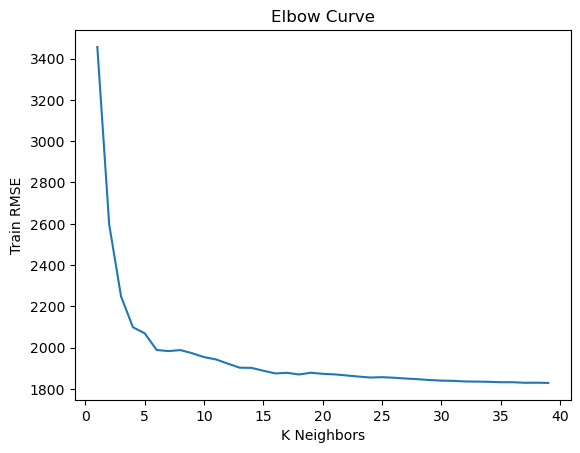

In [120]:
plt.plot(K,test)
plt.xlabel("K Neighbors")
plt.ylabel("Test RMSE")
plt.title("Elbow Curve")

The plot decreases and remains constant from almost 30, the best K value is from 30.
I am choosing my K value to be 35

In [121]:
reg = KNN(n_neighbors = 35)
# Fitting the model
reg.fit(train_x, train_y)
# Predicting over the Train Set and calculating MSE
test_predict = reg.predict(test_x)
error_MSE = mse(test_predict, test_y)
error_RMSE=np.sqrt(error_MSE)
print('Test RMSE    ', error_RMSE )

Test RMSE     1832.66892716076


In [197]:
reg = KNN(n_neighbors = 35)
# Fitting the model
reg.fit(train_x, train_y)
# Predicting over the Train Set and calculating MSE
train_predict = reg.predict(train_x)
error_MSE = mse(train_predict, train_y)
error_RMSE=np.sqrt(error_MSE)
print('Train RMSE    ', error_RMSE )

Train RMSE     3053.6460354145934


# 4.Build a Linear model for the given dataset with regularisation. Attempt to interpret the variable coefficients of the Linear Model

In [130]:
data.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
4120        -73.981094        40.782597         -73.871048         40.773968   
3518        -73.789894        40.646797         -73.904617         40.661068   
8388        -73.989563        40.737545         -73.986168         40.767525   
7968        -73.988380        40.764111         -73.988632         40.773899   
1314        -73.971535        40.795170         -73.968796         40.801785   

      trip_duration  pickup_day  dropoff_day  pickup_month  dropoff_month  \
4120           2199          26           26             5              5   
3518           1283          14           14             6              6   
8388           1356          26           26             3              3   
7968            499          11           11             2              2   
1314            214          14           14             3              3   

      pickup_year  ...  vendor_id_2  passenger_count_0  passenger_count_1  \
4120         2016  ...            1                  0                  1   
3518         2016  ...            1                  0                  1   
8388         2016  ...            0                  0                  1   
7968         2016  ...            1                  0                  1   
1314         2016  ...            0                  0                  0   

      passenger_count_2  passenger_count_3  passenger_count_4  \
4120                  0                  0                  0   
3518                  0                  0                  0   
8388                  0                  0                  0   
7968                  0                  0                  0   
1314                  0                  0                  1   

      passenger_count_5  passenger_count_6  store_and_fwd_flag_N  \
4120                  0                  0                     1   
3518                  0                  0                     1   
8388                  0                  0                     1   
7968                  0                  0                     1   
1314                  0                  0                     1   

      store_and_fwd_flag_Y  
4120                     0  
3518                     0  
8388                     0  
7968                     0  
1314                     0  

[5 rows x 29 columns]

In [152]:
#segregating dependent and independent variables
x=data.drop(['trip_duration'],axis=1)
y=data['trip_duration']
x.shape,y.shape

((10000, 28), (10000,))

In [153]:
#scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
x_scaled=scaler.fit_transform(x)

In [154]:
x=pd.DataFrame(x_scaled,columns=x.columns)
x.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0          0.433265         0.598665           0.484453          0.587987   
1          0.855708         0.430613           0.451603          0.448273   
2          0.414554         0.542914           0.371802          0.580014   
3          0.417167         0.575788           0.369390          0.587902   
4          0.454386         0.614224           0.388801          0.622410   

   pickup_day  dropoff_day  pickup_month  dropoff_month  pickup_year  \
0    0.833333     0.833333           0.8       0.666667          0.0   
1    0.433333     0.433333           1.0       0.833333          0.0   
2    0.833333     0.833333           0.4       0.333333          0.0   
3    0.333333     0.333333           0.2       0.166667          0.0   
4    0.433333     0.433333           0.4       0.333333          0.0   

   dropoff_year  ...  vendor_id_2  passenger_count_0  passenger_count_1  \
0           0.0  ...          1.0                0.0                1.0   
1           0.0  ...          1.0                0.0                1.0   
2           0.0  ...          0.0                0.0                1.0   
3           0.0  ...          1.0                0.0                1.0   
4           0.0  ...          0.0                0.0                0.0   

   passenger_count_2  passenger_count_3  passenger_count_4  passenger_count_5  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                1.0                0.0   

   passenger_count_6  store_and_fwd_flag_N  store_and_fwd_flag_Y  
0                0.0                   1.0                   0.0  
1                0.0                   1.0                   0.0  
2                0.0                   1.0                   0.0  
3                0.0                   1.0                   0.0  
4                0.0                   1.0                   0.0  

[5 rows x 28 columns]

In [155]:
#train test split
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=56)

In [156]:
from sklearn.linear_model import LinearRegression as LR

In [157]:
lr=LR()

In [158]:
lr.fit(train_x,train_y)

LinearRegression()

In [159]:
train_predict=lr.predict(train_x)
error_MSE=MSE(train_predict,train_y)
error_RMSE=np.sqrt(error_MSE)
print("Training score:",error_RMSE)

Training score: 981.0204756917066


In [160]:
test_predict=lr.predict(test_x)
error_MSE=MSE(test_predict,test_y)
error_RMSE=np.sqrt(error_MSE)
print("Testing score:",error_RMSE)

Testing score: 118.79940706285618


In [137]:
#parameters of lr

In [138]:
lr.coef_

array([ 4.82500138e+01, -5.09033540e+02,  1.12006596e+02,  9.53902127e+01,
       -2.44921262e+06,  2.44921963e+06, -1.24581707e+07,  1.49497633e+07,
        1.43633224e-06,  1.41747296e-06, -7.88312848e+04,  7.88435284e+04,
       -3.34514879e+03,  3.34958245e+03, -1.61523803e+01,  5.02076397e+01,
        4.12889193e+02,  5.47663278e-01, -5.47664770e-01, -1.43334831e+01,
       -2.21011412e+01, -1.82971078e+01, -1.12181986e+00, -1.55638680e+01,
        7.63472038e+01, -4.92978563e+00, -9.95884547e+00,  9.95884648e+00])

In [139]:
#plotting the coefficients

Text(0.5, 1.0, 'Coefficient plot')

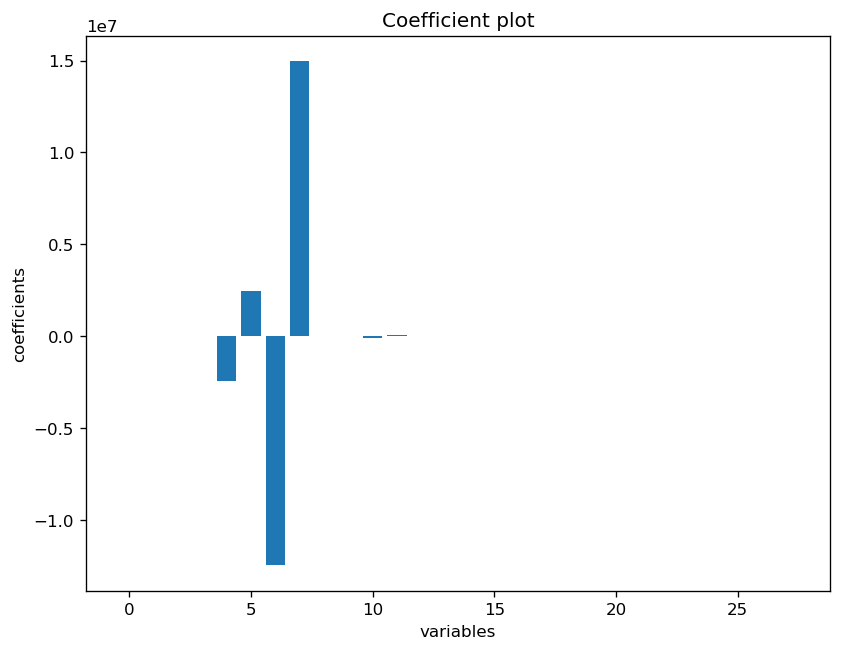

In [140]:
plt.figure(figsize=(8,6),dpi=120,facecolor='w',edgecolor='b')
x=range(len(train_x.columns))
y=lr.coef_
plt.bar(x,y)
plt.xlabel("variables")
plt.ylabel("coefficients")
plt.title("Coefficient plot")

Checking assumptions of linear model

In [141]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()

fitted values  predicted values  residuals
4415            225        246.063826 -21.063826
2522            259        294.674684 -35.674684
5907           2135       2141.234893  -6.234893
4074           1167       1142.139440  24.860560
9396            415        483.764791 -68.764791

In [142]:
residuals.shape

(2500, 3)

In [143]:
#Plotting residual curve (Is there constant variance?)

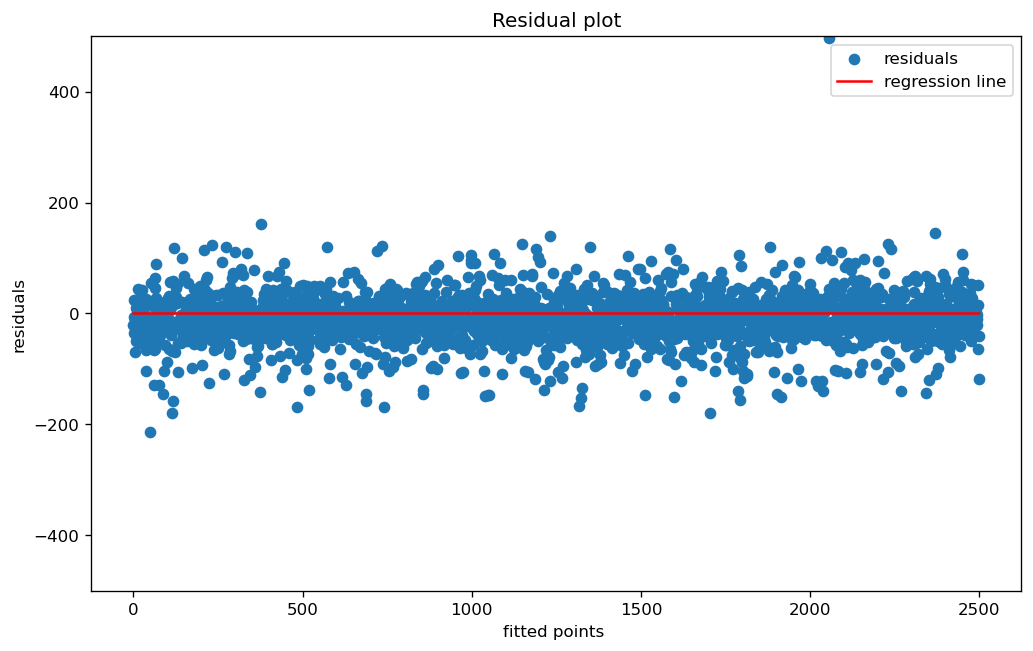

In [144]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,2500)
k = [0 for i in range(0,2500)]
plt.scatter( f, residuals.residuals[:], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-500, 500)
plt.legend()

The variance of the error is nearly constant

In [145]:
#Checking distribution of Residuals

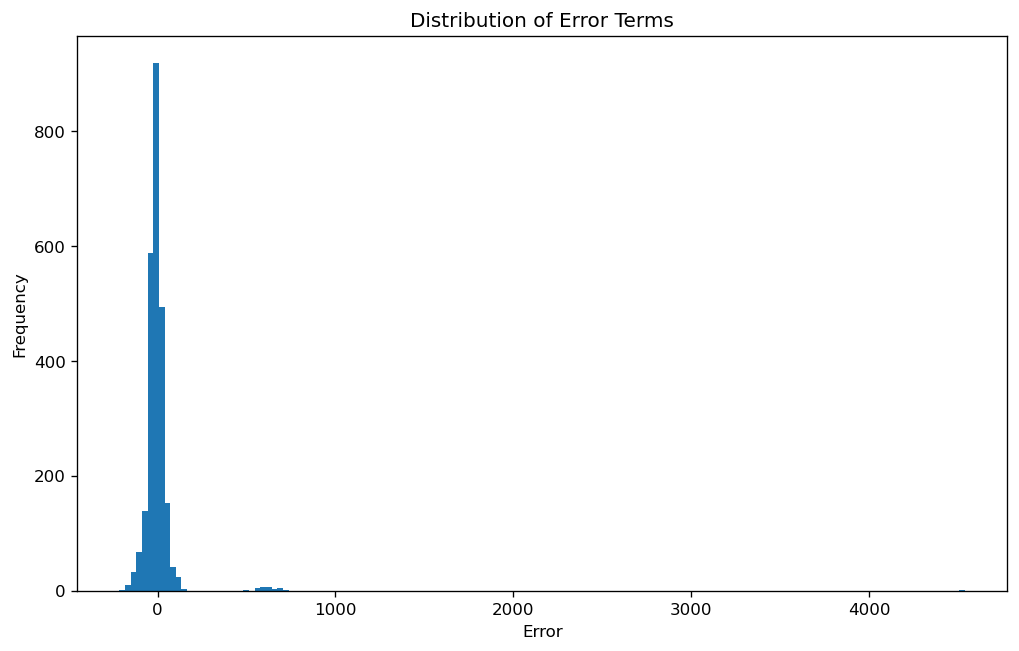

In [146]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals,bins=150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

In [147]:
#QQ-plot is the data normally distributed?

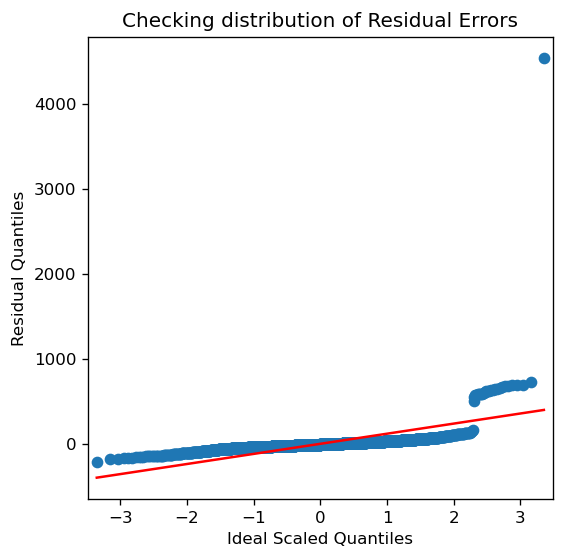

In [148]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

In [149]:
#Variance Inflation Factor (checking for multicollinearity)

In [150]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column (only works for the not Catagorical)
VIF = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index =data.columns)
VIF

pickup_longitude        1.245235e+00
pickup_latitude         1.338976e+00
dropoff_longitude       1.114817e+00
dropoff_latitude        1.312142e+00
trip_duration           1.114623e+01
pickup_day              7.704587e+05
dropoff_day             7.702566e+05
pickup_month            2.702124e+07
dropoff_month           2.702879e+07
pickup_year             0.000000e+00
dropoff_year            0.000000e+00
pickup_hour             7.406120e+02
dropoff_hour            7.595428e+02
pickup_minute           2.492603e+00
dropoff_minute          2.524702e+00
pickup_second           1.002158e+00
dropoff_second          1.003925e+00
distance                1.259629e+00
vendor_id_1                      inf
vendor_id_2                      inf
passenger_count_0                inf
passenger_count_1                inf
passenger_count_2                inf
passenger_count_3                inf
passenger_count_4                inf
passenger_count_5                inf
passenger_count_6                inf
s

In [151]:
#Model interpretability

In [161]:
lr=LR(normalize=True)

In [162]:
lr.fit(train_x,train_y)

LinearRegression(normalize=True)

In [165]:
train_predict=lr.predict(train_x)
error_MSE=MSE(train_predict,train_y)
error_RMSE=np.sqrt(error_MSE)
print("Training score:",error_RMSE)

Training score: 981.0204756917157


In [164]:
test_predict=lr.predict(test_x)
error_MSE=MSE(test_predict,test_y)
error_RMSE=np.sqrt(error_MSE)
print("Testing score:",error_RMSE)

Testing score: 118.79940706346329


In [166]:
lr.coef_

array([ 4.82500138e+01, -5.09033540e+02,  1.12006596e+02,  9.53902127e+01,
       -2.44921262e+06,  2.44921963e+06, -1.24581707e+07,  1.49497633e+07,
       -2.98023224e-08, -2.02581286e-05, -7.88312848e+04,  7.88435284e+04,
       -3.34514879e+03,  3.34958245e+03, -1.61523803e+01,  5.02076397e+01,
        4.12889193e+02,  5.47665842e-01, -5.47662205e-01, -7.66126921e+00,
       -1.54289274e+01, -1.16248940e+01,  5.55039398e+00, -8.89165417e+00,
        8.30194177e+01,  1.74242822e+00, -9.95884719e+00,  9.95884477e+00])

Text(0.5, 1.0, 'Normalized Coefficient plot')

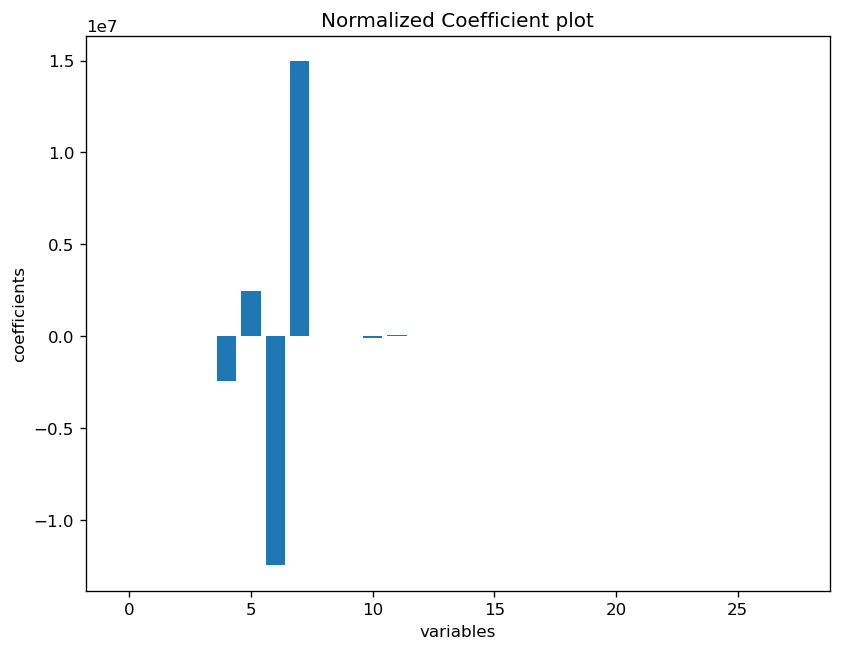

In [167]:
plt.figure(figsize=(8,6),dpi=120,facecolor='w',edgecolor='b')
x=range(len(train_x.columns))
y=lr.coef_
plt.bar(x,y)
plt.xlabel("variables")
plt.ylabel("coefficients")
plt.title("Normalized Coefficient plot")

In [168]:
#Creating new subsets of data

In [169]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((10000, 28), (10000,))

In [170]:
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients.head()

Variable   coefficient
0   pickup_longitude  4.825001e+01
1    pickup_latitude -5.090335e+02
2  dropoff_longitude  1.120066e+02
3   dropoff_latitude  9.539021e+01
4         pickup_day -2.449213e+06

In [171]:
sig_var = Coefficients[Coefficients.coefficient > 0.5]  #Choosing variables with significance greater than 0.5

In [172]:
subset = data[sig_var['Variable'].values]
subset.head()

pickup_longitude  dropoff_longitude  dropoff_latitude  dropoff_day  \
4120        -73.981094         -73.871048         40.773968           26   
3518        -73.789894         -73.904617         40.661068           14   
8388        -73.989563         -73.986168         40.767525           26   
7968        -73.988380         -73.988632         40.773899           11   
1314        -73.971535         -73.968796         40.801785           14   

      dropoff_month  dropoff_hour  dropoff_minute  dropoff_second  distance  \
4120              5            12              26               5  1.319797   
3518              6            23              53              18  1.447701   
8388              3            23              14              10  0.027155   
7968              2            20               8              36  0.000928   
1314              3            14              16               3  0.000363   

      vendor_id_1  passenger_count_3  passenger_count_5  passenger_count_6  \
4120            0                  0                  0                  0   
3518            0                  0                  0                  0   
8388            1                  0                  0                  0   
7968            0                  0                  0                  0   
1314            1                  0                  0                  0   

      store_and_fwd_flag_Y  
4120                     0  
3518                     0  
8388                     0  
7968                     0  
1314                     0

In [173]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(subset, y , random_state = 56)

In [174]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE

In [175]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

In [176]:
train_predict=lr.predict(train_x)
error_MSE=MSE(train_predict,train_y)
error_RMSE=np.sqrt(error_MSE)
print("Training score:",error_RMSE)

Training score: 3091.140263237676


In [177]:
test_predict=lr.predict(test_x)
error_MSE=MSE(test_predict,test_y)
error_RMSE=np.sqrt(error_MSE)
print("Testing score:",error_RMSE)

Testing score: 1760.4101754234136


Text(0.5, 1.0, 'Normalized Coefficient plot')

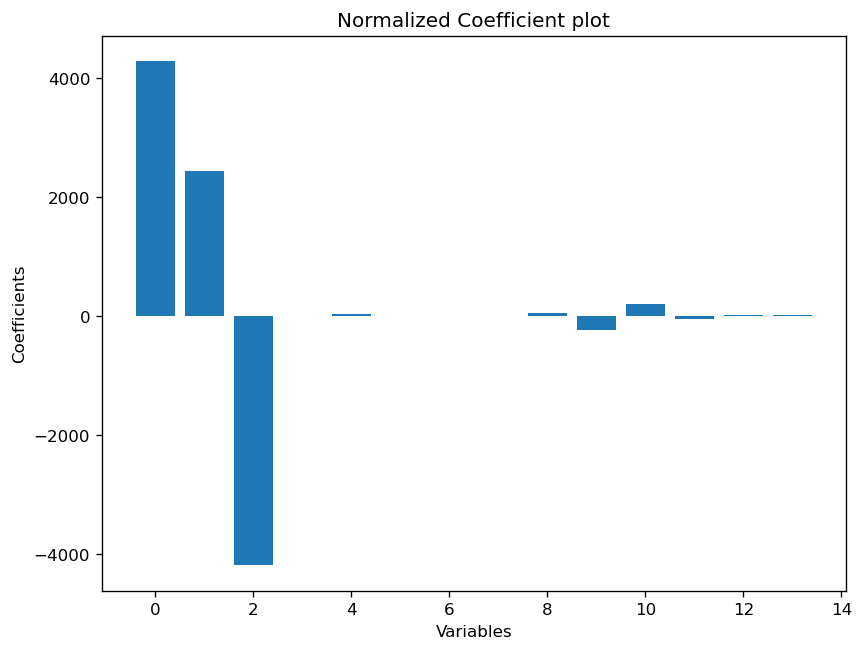

In [178]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

Performing Regularization

I am performing Lasso Regularization because in Ridge Regularization, nullified coefficients will still participate that makes it difficult to interpret.

In [203]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1)
lasso_reg.fit(train_x,train_y)

train_y_pred = lasso_reg.predict(train_x)
error_MSE=MSE(train_y_pred,train_y)
error_RMSE=np.sqrt(error_MSE)
print("Training score:",error_RMSE)

test_y_pred = lasso_reg.predict(test_x)
error_MSE=MSE(test_y_pred,test_y)
error_RMSE=np.sqrt(error_MSE)
print("Testing score:",error_RMSE)

lasso_coeff=pd.DataFrame()
lasso_coeff['Columns']=train_x.columns
lasso_coeff['Coefficient Estimate']=pd.Series(lasso_reg.coef_)
print(lasso_coeff)


Training score: 3091.582192612917
Testing score: 1759.6042502285422
                 Columns  Coefficient Estimate
0       pickup_longitude           3563.986806
1      dropoff_longitude           1649.829755
2       dropoff_latitude          -3020.722232
3            dropoff_day              3.961422
4          dropoff_month             29.106008
5           dropoff_hour             -4.051122
6         dropoff_minute             -1.814828
7         dropoff_second             -4.503710
8               distance             58.996055
9            vendor_id_1           -224.702027
10     passenger_count_3            180.049708
11     passenger_count_5            -31.867452
12     passenger_count_6              0.000000
13  store_and_fwd_flag_Y              0.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

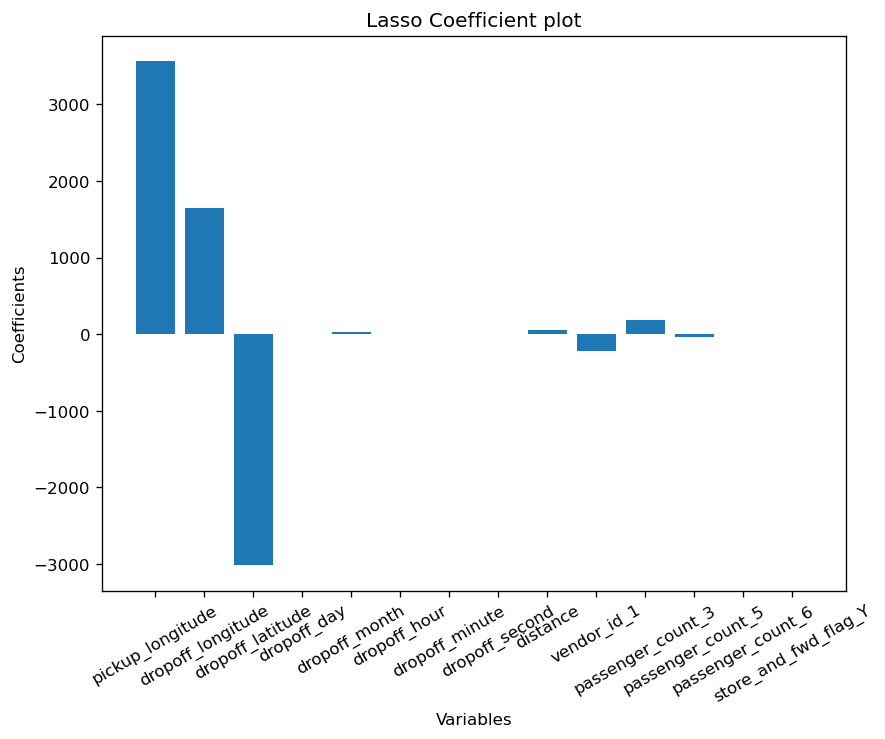

In [204]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = lasso_coeff['Columns']
y = lasso_coeff['Coefficient Estimate']
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient plot')
plt.xticks(rotation=30)

In [205]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1e-5)
lasso_reg.fit(train_x,train_y)

train_y_pred = lasso_reg.predict(train_x)
error_MSE=MSE(train_y_pred,train_y)
error_RMSE=np.sqrt(error_MSE)
print("Training score:",error_RMSE)

test_y_pred = lasso_reg.predict(test_x)
error_MSE=MSE(test_y_pred,test_y)
error_RMSE=np.sqrt(error_MSE)
print("Testing score:",error_RMSE)

lasso_coeff=pd.DataFrame()
lasso_coeff['Columns']=train_x.columns
lasso_coeff['Coefficient Estimate']=pd.Series(lasso_reg.coef_)
print(lasso_coeff)


Training score: 3091.140263237722
Testing score: 1760.4101603316453
                 Columns  Coefficient Estimate
0       pickup_longitude           4280.836277
1      dropoff_longitude           2439.847382
2       dropoff_latitude          -4190.743167
3            dropoff_day              3.835180
4          dropoff_month             29.075554
5           dropoff_hour             -3.840258
6         dropoff_minute             -1.780418
7         dropoff_second             -4.552267
8               distance             53.081198
9            vendor_id_1           -228.581196
10     passenger_count_3            202.837681
11     passenger_count_5            -55.716817
12     passenger_count_6             14.824553
13  store_and_fwd_flag_Y             18.506795


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

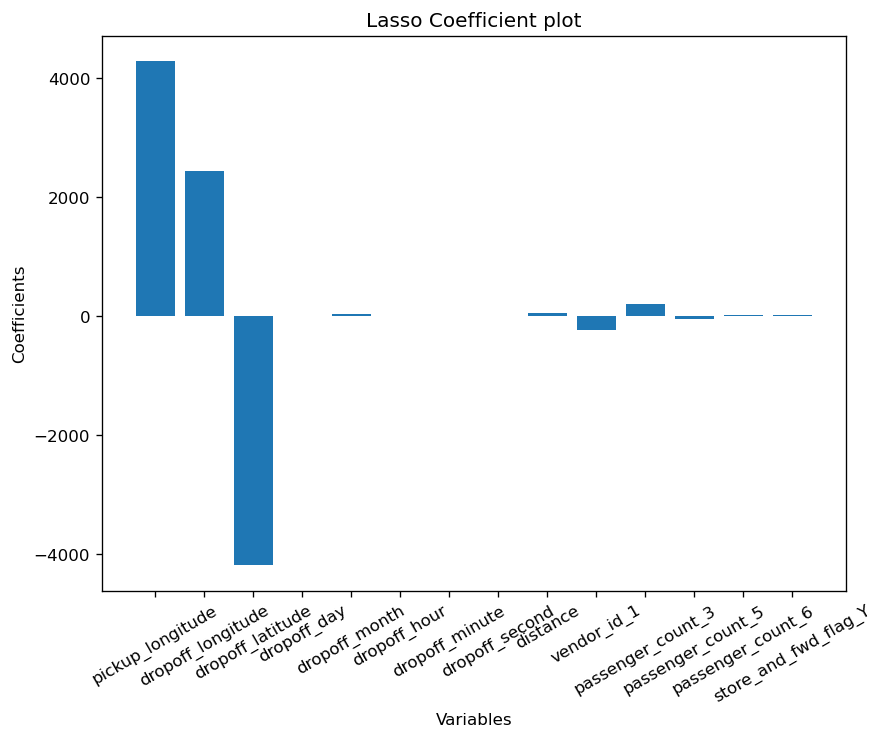

In [206]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = lasso_coeff['Columns']
y = lasso_coeff['Coefficient Estimate']
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient plot')
plt.xticks(rotation=30)

In [207]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.01)
lasso_reg.fit(train_x,train_y)

train_y_pred = lasso_reg.predict(train_x)
error_MSE=MSE(train_y_pred,train_y)
error_RMSE=np.sqrt(error_MSE)
print("Training score:",error_RMSE)

test_y_pred = lasso_reg.predict(test_x)
error_MSE=MSE(test_y_pred,test_y)
error_RMSE=np.sqrt(error_MSE)
print("Testing score:",error_RMSE)

lasso_coeff=pd.DataFrame()
lasso_coeff['Columns']=train_x.columns
lasso_coeff['Coefficient Estimate']=pd.Series(lasso_reg.coef_)
print(lasso_coeff)


Training score: 3091.140310777294
Testing score: 1760.3950505421742
                 Columns  Coefficient Estimate
0       pickup_longitude           4273.714073
1      dropoff_longitude           2431.932387
2       dropoff_latitude          -4179.042131
3            dropoff_day              3.836373
4          dropoff_month             29.075776
5           dropoff_hour             -3.842391
6         dropoff_minute             -1.780859
7         dropoff_second             -4.551600
8               distance             53.141098
9            vendor_id_1           -228.534713
10     passenger_count_3            202.617540
11     passenger_count_5            -55.488623
12     passenger_count_6             14.532652
13  store_and_fwd_flag_Y             16.745541


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

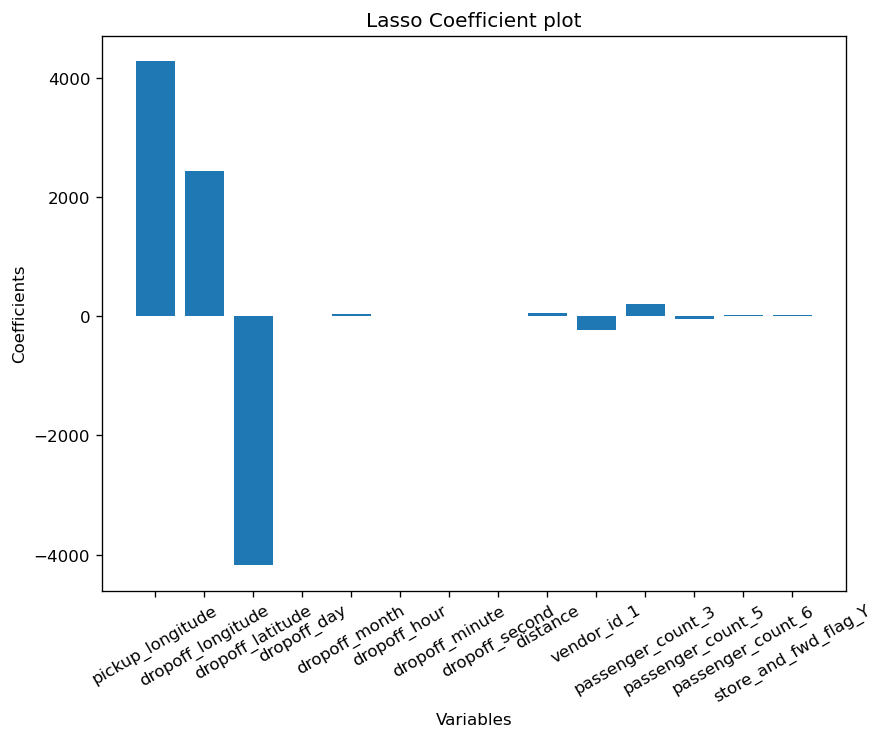

In [208]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = lasso_coeff['Columns']
y = lasso_coeff['Coefficient Estimate']
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient plot')
plt.xticks(rotation=30)

I changed different alpha values to see how my coefficients are being varied

# 6.Plot the following Bar plots: train score of all the above models. test (not validation!) score of all the above models

In [214]:
Train_Score=pd.DataFrame()
Train_Score['Models']=['KNN_train','LR_train','LR_train_Normalized','LR_train_regularized_1','LR_train_regularized_1e-5','LR_train_regularized_0.01']
Train_Score['Train Score']=[3053.6460354145934,981.0204756917066,3091.140263237676,3091.582192612917,3091.140263237722,3091.140310777294]

Train_Score

Models  Train Score
0                  KNN_train  3053.646035
1                   LR_train   981.020476
2        LR_train_Normalized  3091.140263
3     LR_train_regularized_1  3091.582193
4  LR_train_regularized_1e-5  3091.140263
5  LR_train_regularized_0.01  3091.140311

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

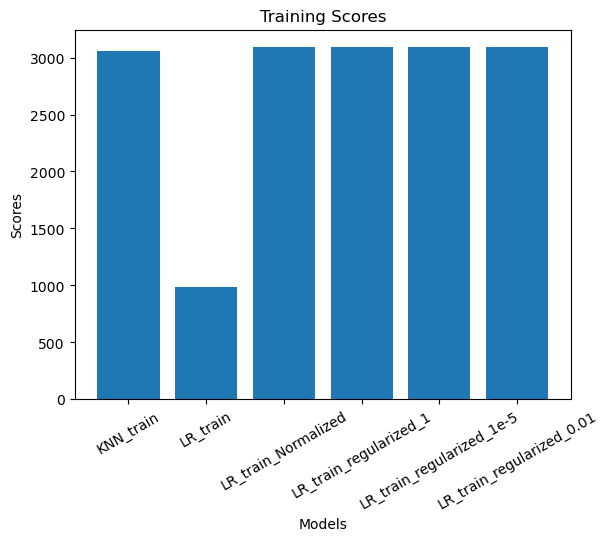

In [217]:
plt.bar(Train_Score['Models'],Train_Score['Train Score'])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Training Scores")
plt.xticks(rotation=30)

In [218]:
Test_Score=pd.DataFrame()
Test_Score['Models']=['benchmark_simple_mean','benchmark_ven_id_mean','benchmark_pass_count_mean','benchmark_month_mean',
                      'benchmark_pickuphour_mean','benchmark_pickupdate_mean','benchmark_super_mean',
                      'KNN_test','LR_test','LR_test_Normalized','LR_test_regularized_1','LR_test_regularized_1e-5',
                      'LR_test_regularized_0.01']
Test_Score['Test Score']=[2653.03294498059,2651.296742772723,2655.6306075725115,2653.773785624259,2658.263620947929,2702.8373377497787,2651.8778013574643,
                         1832.66892716076,118.79940706285618,1760.4101754234136,1759.6042502285422,1760.4101603316453,
                         1760.3950505421742]

Test_Score

Models   Test Score
0       benchmark_simple_mean  2653.032945
1       benchmark_ven_id_mean  2651.296743
2   benchmark_pass_count_mean  2655.630608
3        benchmark_month_mean  2653.773786
4   benchmark_pickuphour_mean  2658.263621
5   benchmark_pickupdate_mean  2702.837338
6        benchmark_super_mean  2651.877801
7                    KNN_test  1832.668927
8                     LR_test   118.799407
9          LR_test_Normalized  1760.410175
10      LR_test_regularized_1  1759.604250
11   LR_test_regularized_1e-5  1760.410160
12   LR_test_regularized_0.01  1760.395051

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

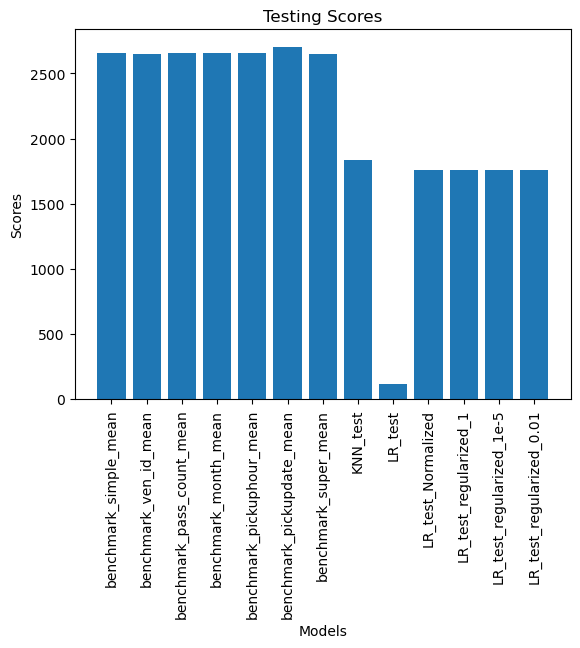

In [222]:
plt.bar(Test_Score['Models'],Test_Score['Test Score'])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Testing Scores")
plt.xticks(rotation=90)